# PBL4

Implementación de las ideas mostradas en el paper "Learning in two-player games between transparent opponents"

## Importación de librerías

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch as T
import datetime

Cálculo de las probabilidades de acción para 2 jugadores, 2 juegos de acción, en donde cada jugador puede predecir al otro

In [ ]:
def transparent_decision_making(params_A, params_B, epsilon=1e-3):
    """
    Decision-making under mutual transparency for a 2-player, 2-action game.
    Inputs: tensors of shape [4], describing players' parameters, which are 
    converted to probabilities using sigmoid.
    Parameter 0 -> Pr[0|~P] (probability of choosing action 0 when not 
                             predicting the opponent)
    Parameter 1 -> Pr[0|0] (probability of choosing action 0 when the opponent's 
                            predicted action is 0)
    Parameter 2 -> Pr[0|1] (probability of choosing action 0 when the opponent's 
                            predicted action is 1)
    Parameter 3 -> Pr[P] (probability of predicting the opponent)
    epsilon is the minimial probability of an opponent-independent response.
    Returns both players' probabilities of playing action 0.
    """
    probs_A = T.sigmoid(params_A[:3])
    probs_A = T.stack([probs_A, 1 - probs_A])
    v_A = probs_A[:, 0]
    M_A = probs_A[:, 1:]
    p_simu_A = T.clamp(T.sigmoid(params_A[3]), 0, 1-epsilon)

    probs_B = T.sigmoid(params_B[:3])
    probs_B = T.stack([probs_B, 1 - probs_B])
    v_B = probs_B[:, 0]
    M_B = probs_B[:, 1:]
    p_simu_B = T.clamp(T.sigmoid(params_B[3]), 0, 1-epsilon)

    R_A = (1-p_simu_A) * v_A + p_simu_A * (1-p_simu_B) * T.matmul(M_A, v_B)
    S_A = T.eye(2) - p_simu_B * p_simu_A * T.matmul(M_A, M_B)
    response_A = T.matmul(T.inverse(S_A), R_A)
    R_B = (1-p_simu_B) * v_B + p_simu_B * (1-p_simu_A) * T.matmul(M_B, v_A)
    S_B = T.eye(2) - p_simu_A * p_simu_B * T.matmul(M_B, M_A) 
    response_B = T.matmul(T.inverse(S_B), R_B)
    
    assert T.allclose(T.sum(response_A), T.tensor(1.), rtol=1e-3), \
        'response_A not normalized'
    assert T.allclose(T.sum(response_B), T.tensor(1.), rtol=1e-3), \
        'response_B not normalized'
    assert (response_A >= 0.).byte().all(), 'response_A not non-negative'
    assert (response_B >= 0.).byte().all(), 'response_B not non-negative'

    return (response_A[0], response_B[0])

Para ilustración, se ha probado con los siguientes estados:

*   "defector": Defectos incondicionales con alta probabilidad
*   "cooperator": Incondicionalmente coopera con alta probabilidad
*   "coin fliper": Toma cada acción posible con probabilidad 1/2
*   "eGroundedFairBot": Incondicionalmente coopera con una baja probabilidad, de otra manera refleja las acciones del oponente



In [ ]:
# Assume action 0 is cooperation, and action 1 is defection.
agents = [
          ('defector', T.tensor([-20.,-20.,-20.,-20.])),
          ('cooperator', T.tensor([20.,20.,20.,-20.])),
          ('coin_fliper', T.tensor([0.,0.,0.,0.])),
          ('epsilon_grounded_fair_bot', T.tensor([20.,20.,-20.,20.])),
]
for i, agent_A in enumerate(agents):
    for j, agent_B in enumerate(agents):
        if j < i:
            continue
        pr_C_A, pr_C_B = transparent_decision_making(agent_A[1], agent_B[1])
        msg = f"Agent A = {agent_A[0]}, agent B = {agent_B[0]}, "
        msg += f"Pr[C]_A = {pr_C_A:.3f}, Pr[C]_B = {pr_C_B:.3f}"
        print(msg)

Agent A = defector, agent B = defector, Pr[C]_A = 0.000, Pr[C]_B = 0.000
Agent A = defector, agent B = cooperator, Pr[C]_A = 0.000, Pr[C]_B = 1.000
Agent A = defector, agent B = coin_fliper, Pr[C]_A = 0.000, Pr[C]_B = 0.500
Agent A = defector, agent B = epsilon_grounded_fair_bot, Pr[C]_A = 0.000, Pr[C]_B = 0.001
Agent A = cooperator, agent B = cooperator, Pr[C]_A = 1.000, Pr[C]_B = 1.000
Agent A = cooperator, agent B = coin_fliper, Pr[C]_A = 1.000, Pr[C]_B = 0.500
Agent A = cooperator, agent B = epsilon_grounded_fair_bot, Pr[C]_A = 1.000, Pr[C]_B = 1.000
Agent A = coin_fliper, agent B = coin_fliper, Pr[C]_A = 0.500, Pr[C]_B = 0.500
Agent A = coin_fliper, agent B = epsilon_grounded_fair_bot, Pr[C]_A = 0.500, Pr[C]_B = 0.501
Agent A = epsilon_grounded_fair_bot, agent B = epsilon_grounded_fair_bot, Pr[C]_A = 1.000, Pr[C]_B = 1.000


In [ ]:
def actions_to_payoffs(game, p_C_A, p_C_B):
    p_CC, p_CD, p_DC, p_DD = p_C_A * p_C_B, p_C_A * (1-p_C_B), \
                             (1-p_C_A) * p_C_B, (1-p_C_A) * (1-p_C_B)
    if game == 'prisoners_dilemma':
        S, P, R, T = 0, 10, 30, 40
    elif game == 'chicken':
        S, P, R, T = 0, -30, 30, 40
    else:
        raise ValueError(f"unsupported game '{game}'")
    V_A = p_CC * R + p_CD * S + p_DC * T + p_DD * P
    V_B = p_CC * R + p_CD * T + p_DC * S + p_DD * P
    return (V_A, V_B)

In [ ]:
def naive_gradients(params_A, params_B, params_to_payoffs):
    V_A, V_B = params_to_payoffs(params_A, params_B)
    grad_A = T.autograd.grad(V_A, params_A, create_graph=True)[0]
    grad_B = T.autograd.grad(V_B, params_B)[0]
    return grad_A, grad_B

In [ ]:
def lola_gradients(params_A, params_B, eta_A, eta_B, params_to_payoffs):
    grad = T.autograd.grad
    V_A, V_B = params_to_payoffs(params_A, params_B)
    grad_naive_A = grad(V_A, params_A, create_graph=True)[0]
    grad_naive_B = grad(V_B, params_B, create_graph=True)[0]
    params_lookahead_A = params_A + eta_B * grad_naive_A.detach()
    params_lookahead_B = params_B + eta_A * grad_naive_B.detach()
    V_lookahead_A, _ = params_to_payoffs(params_A, params_lookahead_B)
    _, V_lookahead_B = params_to_payoffs(params_lookahead_A, params_B)
    grad_A = grad(V_lookahead_A, params_A, create_graph=True)[0]
    grad_B = grad(V_lookahead_B, params_B, create_graph=True)[0]
    def shaping_correction(params_self, params_opponent, V_lookahead_self, 
                           grad_naive_opponent):
        vec = grad(V_lookahead_self, params_opponent)[0].detach()
        return grad(T.matmul(vec, grad_naive_opponent), params_self, 
                    retain_graph=True)[0]
    grad_A += eta_A * shaping_correction(params_A, params_B, V_lookahead_A, 
                                         grad_naive_B)
    grad_B += eta_B * shaping_correction(params_B, params_A, V_lookahead_B, 
                                         grad_naive_A)
    return grad_A, grad_B

In [ ]:
def sos_gradients(params_A, params_B, eta_A, eta_B, params_to_payoffs,
                  a=0.5, b=0.1):
    V_A, V_B = params_to_payoffs(params_A, params_B)
    grad = lambda fun, params: T.autograd.grad(fun, params, 
                                               create_graph=True)[0]
    grad_A_A = grad(V_A, params_A)
    grad_A_B = grad(V_A, params_B)
    grad_B_A = grad(V_B, params_A)
    grad_B_B = grad(V_B, params_B)
    xi_0_A = grad_A_A + \
             eta_A * grad(T.dot(grad_A_B, grad_B_B.detach()), params_A)
    xi_0_B = grad_B_B + \
             eta_B * grad(T.dot(grad_B_A, grad_A_A.detach()), params_B)
    chi_A = eta_A * grad(T.dot(grad_A_B.detach(), grad_B_B), params_A) 
    chi_B = eta_B * grad(T.dot(grad_B_A.detach(), grad_A_A), params_B)
    def p(grad_naive, xi_0, chi):
        dot_prod = T.dot(chi, xi_0)
        p_1 = 1 if dot_prod >= 0 else min(1, -a * T.norm(xi_0)**2 / dot_prod)
        grad_naive_norm = T.norm(grad_naive)
        p_2 = grad_naive_norm**2 if grad_naive_norm < b else 1
        return min(p_1, p_2)
    grad_A = xi_0_A + p(grad_A_A, xi_0_A, chi_A) * chi_A
    grad_B = xi_0_B + p(grad_B_B, xi_0_B, chi_B) * chi_B
    assert T.dot(grad_A, xi_0_A) >= 0 and T.dot(grad_B, xi_0_B) >= 0
    return grad_A, grad_B

In [ ]:
def learn(game, 
          algo_A,
          algo_B,
          lr_A=1, 
          lr_B=1, 
          eta_A=1, 
          eta_B=1,
          std=0.1,
          n_steps=400,
          ):
    assert game in {'prisoners_dilemma', 'chicken'}
    assert all(algo in {'naive', 'lola', 'sos'} for algo in [algo_A, algo_B])

    def params_to_payoffs(params_A, params_B):
        p_C_A, p_C_B = transparent_decision_making(params_A, params_B)
        V_A, V_B = actions_to_payoffs(game, p_C_A, p_C_B)
        return (V_A, V_B)

    params_A = std * T.randn(4)
    params_B = std * T.randn(4)
    params_A.requires_grad_()
    params_B.requires_grad_()
    outcomes = []
    for i in range(n_steps):
        p_C_A, p_C_B = transparent_decision_making(params_A, params_B)
        V_A, V_B = actions_to_payoffs(game, p_C_A, p_C_B)
        outcome = {'p_C_A': p_C_A.detach().numpy(), 
                   'p_C_B': p_C_B.detach().numpy(), 
                   'V_A': V_A.item(), 
                   'V_B': V_B.item(),
                   }
        outcomes.append(outcome)
        grad_naive_A, grad_naive_B, grad_lola_A, grad_lola_B, \
        grad_sos_A, grad_sos_B = (None,) * 6
        if algo_A == 'naive' or algo_B == 'naive':
            grad_naive_A, grad_naive_B = \
                naive_gradients(params_A, params_B, params_to_payoffs)
        if algo_A == 'lola' or algo_B == 'lola':
            grad_lola_A, grad_lola_B = \
                lola_gradients(params_A, params_B, 
                               eta_A, eta_B, 
                               params_to_payoffs)
        if algo_A == 'sos' or algo_B == 'sos':
            grad_sos_A, grad_sos_B = \
                sos_gradients(params_A, params_B, eta_A, eta_B, 
                              params_to_payoffs)
        grad_A, grad_B = None, None
        if algo_A == 'naive':
            grad_A = grad_naive_A
        elif algo_A == 'lola':
            grad_A = grad_lola_A
        elif algo_A == 'sos':
            grad_A = grad_sos_A
        if algo_B == 'naive':
            grad_B = grad_naive_B
        elif algo_B == 'lola':
            grad_B = grad_lola_B
        elif algo_B == 'sos':
            grad_B = grad_sos_B
        assert grad_A is not None and grad_B is not None
        with T.no_grad():
            params_A += lr_A * grad_A
            params_B += lr_B * grad_B
    
    return outcomes

In [ ]:
def t_to_str(t):
    return str(t.time()).split('.')[0]

def now_str():
    return t_to_str(datetime.datetime.now())

In [ ]:
def experiment(game, 
               algo_A,
               algo_B,
               lr_A=1, 
               lr_B=1, 
               eta_A=1, 
               eta_B=1,
               std=0.1,
               n_steps=200,
               n_sample=100,
               mute=False,
              ):
    all_outcomes = []
    perc = 10
    if not mute:
        print(f"{now_str()}: Starting")
    t_start = datetime.datetime.now()
    for i in range(n_sample):
        if not mute and i >= perc * n_sample / 100:
            t = datetime.datetime.now()
            t_end = t + (t - t_start) * (n_sample - i) / i
            msg = f"{now_str()}: {perc}% done; "
            msg += f"expect to finish at {t_to_str(t_end)}"
            print(msg)
            perc += 10 
        outcomes = learn(game=game, 
                         algo_A=algo_A, 
                         algo_B=algo_B, 
                         lr_A=lr_A, 
                         lr_B=lr_B, 
                         eta_A=eta_A, 
                         eta_B=eta_B, 
                         std=std, 
                         n_steps=n_steps, 
                         )
        all_outcomes.append(outcomes)
    return all_outcomes

In [ ]:
%%time
results_naive = experiment('prisoners_dilemma', algo_A='naive', algo_B='naive')

18:22:54: Starting
18:23:01: 10% done; expect to finish at 18:23:56
18:23:07: 20% done; expect to finish at 18:23:58
18:23:13: 30% done; expect to finish at 18:23:57
18:23:19: 40% done; expect to finish at 18:23:56
18:23:25: 50% done; expect to finish at 18:23:56
18:23:32: 60% done; expect to finish at 18:23:57
18:23:38: 70% done; expect to finish at 18:23:57
18:23:45: 80% done; expect to finish at 18:23:58
18:23:51: 90% done; expect to finish at 18:23:57
CPU times: user 1min 1s, sys: 215 ms, total: 1min 1s
Wall time: 1min 2s


In [ ]:
%%time
results_lola = experiment('prisoners_dilemma', algo_A='lola', algo_B='lola')

18:23:57: Starting
18:24:20: 10% done; expect to finish at 18:27:44
18:24:42: 20% done; expect to finish at 18:27:40
18:25:04: 30% done; expect to finish at 18:27:40
18:25:26: 40% done; expect to finish at 18:27:39
18:25:49: 50% done; expect to finish at 18:27:40
18:26:11: 60% done; expect to finish at 18:27:40
18:26:33: 70% done; expect to finish at 18:27:40
18:26:55: 80% done; expect to finish at 18:27:40
18:27:18: 90% done; expect to finish at 18:27:40
CPU times: user 3min 42s, sys: 505 ms, total: 3min 43s
Wall time: 3min 43s


In [ ]:
%%time
results_sos = experiment('prisoners_dilemma', algo_A='sos', algo_B='sos')

18:27:40: Starting
18:28:10: 10% done; expect to finish at 18:32:36
18:28:39: 20% done; expect to finish at 18:32:34
18:29:09: 30% done; expect to finish at 18:32:35
18:29:38: 40% done; expect to finish at 18:32:34
18:30:07: 50% done; expect to finish at 18:32:33
18:30:36: 60% done; expect to finish at 18:32:33
18:31:03: 70% done; expect to finish at 18:32:31
18:31:32: 80% done; expect to finish at 18:32:30
18:32:00: 90% done; expect to finish at 18:32:29
CPU times: user 4min 47s, sys: 602 ms, total: 4min 48s
Wall time: 4min 47s


### Apartado de combinaciones en PD

In [ ]:
%%time
results_lola_sos = experiment('prisoners_dilemma', algo_A='lola', algo_B='sos')

17:23:48: Starting
17:24:38: 10% done; expect to finish at 17:32:00
17:25:26: 20% done; expect to finish at 17:31:58
17:26:15: 30% done; expect to finish at 17:31:58
17:27:05: 40% done; expect to finish at 17:32:00
17:27:54: 50% done; expect to finish at 17:31:59
17:28:42: 60% done; expect to finish at 17:31:58
17:29:31: 70% done; expect to finish at 17:31:57
17:30:20: 80% done; expect to finish at 17:31:58
17:31:10: 90% done; expect to finish at 17:31:59
CPU times: user 8min 10s, sys: 897 ms, total: 8min 11s
Wall time: 8min 11s


In [ ]:
%%time
results_lola_naive = experiment('prisoners_dilemma', algo_A='lola', algo_B='naive')

17:35:00: Starting
17:35:28: 10% done; expect to finish at 17:39:42
17:35:57: 20% done; expect to finish at 17:39:44
17:36:24: 30% done; expect to finish at 17:39:42
17:36:52: 40% done; expect to finish at 17:39:40
17:37:19: 50% done; expect to finish at 17:39:38
17:37:48: 60% done; expect to finish at 17:39:39
17:38:15: 70% done; expect to finish at 17:39:38
17:38:42: 80% done; expect to finish at 17:39:37
17:39:09: 90% done; expect to finish at 17:39:36
CPU times: user 4min 34s, sys: 587 ms, total: 4min 35s
Wall time: 4min 36s


In [ ]:
%%time
results_naive_sos = experiment('prisoners_dilemma', algo_A='naive', algo_B='sos')

17:39:36: Starting
17:40:11: 10% done; expect to finish at 17:45:22
17:40:44: 20% done; expect to finish at 17:45:17
17:41:18: 30% done; expect to finish at 17:45:17
17:41:53: 40% done; expect to finish at 17:45:18
17:42:27: 50% done; expect to finish at 17:45:18
17:43:02: 60% done; expect to finish at 17:45:19
17:43:35: 70% done; expect to finish at 17:45:18
17:44:08: 80% done; expect to finish at 17:45:16
17:44:41: 90% done; expect to finish at 17:45:15
CPU times: user 5min 38s, sys: 694 ms, total: 5min 39s
Wall time: 5min 38s


### Apartado de Chicken

In [ ]:
%%time
results_naive_c = experiment('chicken', algo_A='naive', algo_B='naive')

17:45:15: Starting
17:45:21: 10% done; expect to finish at 17:46:19
17:45:28: 20% done; expect to finish at 17:46:19
17:45:34: 30% done; expect to finish at 17:46:19
17:45:40: 40% done; expect to finish at 17:46:19
17:45:47: 50% done; expect to finish at 17:46:18
17:45:53: 60% done; expect to finish at 17:46:18
17:45:59: 70% done; expect to finish at 17:46:18
17:46:06: 80% done; expect to finish at 17:46:19
17:46:12: 90% done; expect to finish at 17:46:19
CPU times: user 1min 3s, sys: 234 ms, total: 1min 3s
Wall time: 1min 3s


In [ ]:
%%time
results_lola_c = experiment('chicken', algo_A='lola', algo_B='lola')

17:46:19: Starting
17:46:41: 10% done; expect to finish at 17:50:06
17:47:04: 20% done; expect to finish at 17:50:05
17:47:27: 30% done; expect to finish at 17:50:08
17:47:51: 40% done; expect to finish at 17:50:09
17:48:14: 50% done; expect to finish at 17:50:09
17:48:37: 60% done; expect to finish at 17:50:09
17:49:00: 70% done; expect to finish at 17:50:09
17:49:22: 80% done; expect to finish at 17:50:08
17:49:44: 90% done; expect to finish at 17:50:07
CPU times: user 3min 47s, sys: 469 ms, total: 3min 48s
Wall time: 3min 48s


In [ ]:
%%time
results_sos_c = experiment('chicken', algo_A='sos', algo_B='sos')

17:50:07: Starting
17:50:35: 10% done; expect to finish at 17:54:45
17:51:02: 20% done; expect to finish at 17:54:42
17:51:29: 30% done; expect to finish at 17:54:42
17:51:57: 40% done; expect to finish at 17:54:43
17:52:25: 50% done; expect to finish at 17:54:43
17:52:53: 60% done; expect to finish at 17:54:43
17:53:21: 70% done; expect to finish at 17:54:44
17:53:49: 80% done; expect to finish at 17:54:45
17:54:18: 90% done; expect to finish at 17:54:45
CPU times: user 4min 38s, sys: 274 ms, total: 4min 38s
Wall time: 4min 39s


In [ ]:
%%time
results_lola_sos_c = experiment('chicken', algo_A='lola', algo_B='sos')

In [ ]:
%%time
results_lola_naive_c = experiment('chicken', algo_A='lola', algo_B='naive')

18:02:54: Starting
18:03:21: 10% done; expect to finish at 18:07:19
18:03:47: 20% done; expect to finish at 18:07:19
18:04:14: 30% done; expect to finish at 18:07:19
18:04:40: 40% done; expect to finish at 18:07:20
18:05:08: 50% done; expect to finish at 18:07:21
18:05:34: 60% done; expect to finish at 18:07:20
18:06:00: 70% done; expect to finish at 18:07:20
18:06:27: 80% done; expect to finish at 18:07:20
18:06:53: 90% done; expect to finish at 18:07:20
CPU times: user 4min 25s, sys: 270 ms, total: 4min 25s
Wall time: 4min 25s


In [ ]:
%%time
results_naive_sos_c = experiment('chicken', algo_A='naive', algo_B='sos')

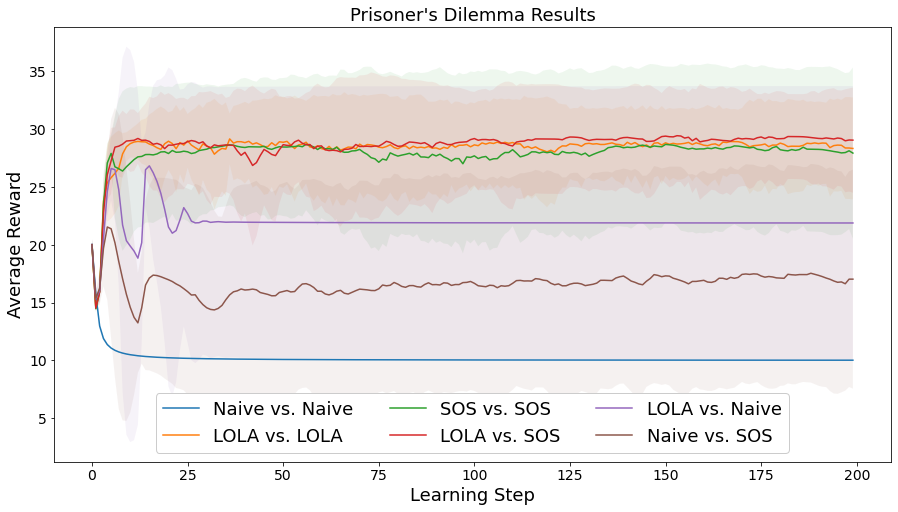

In [ ]:
plt.figure(figsize=(15, 8))
for algo, algo2, outcomes in [('Naive', 'Naive', results_naive),
                       ('LOLA', 'LOLA', results_lola),
                       ('SOS', 'SOS', results_sos),
                       ('LOLA','SOS', results_lola_sos),
                       ('LOLA', 'Naive', results_lola_naive),
                       ('Naive', 'SOS', results_naive_sos) 
                       ]:
    Vs = np.array([[o['V_A'] for o in oo] for oo in outcomes] + \
                  [[o['V_B'] for o in oo] for oo in outcomes])
    means, stds = np.mean(Vs, axis=0), np.std(Vs, axis=0)
    steps = np.arange(len(means))
    plt.plot(steps, means, label=f"{algo} vs. {algo2}")
    plt.fill_between(steps, means-stds, means+stds, alpha=0.08)
plt.title("Prisoner's Dilemma Results", fontsize=18)
plt.xlabel("Learning Step", fontsize=18)
plt.ylabel("Average Reward", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=14)
plt.legend(loc='lower center', frameon=True, framealpha=1, ncol=3, fontsize=18)
plt.show()

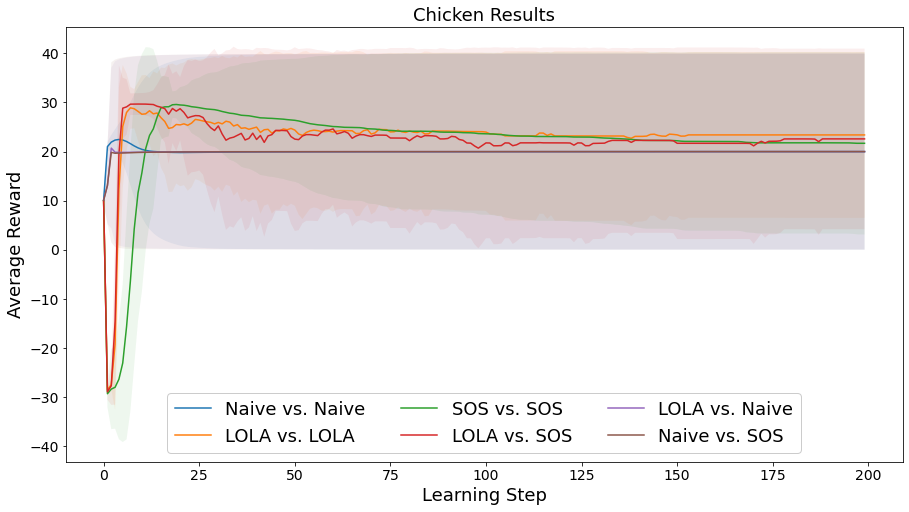

In [ ]:
plt.figure(figsize=(15, 8))
for algo, algo2, outcomes in [('Naive', 'Naive', results_naive_c),
                       ('LOLA', 'LOLA', results_lola_c),
                       ('SOS', 'SOS', results_sos_c),
                       ('LOLA','SOS', results_lola_sos_c),
                       ('LOLA', 'Naive', results_lola_naive_c),
                       ('Naive', 'SOS', results_naive_sos_c) 
                       ]:
    Vs = np.array([[o['V_A'] for o in oo] for oo in outcomes] + \
                  [[o['V_B'] for o in oo] for oo in outcomes])
    means, stds = np.mean(Vs, axis=0), np.std(Vs, axis=0)
    steps = np.arange(len(means))
    plt.plot(steps, means, label=f"{algo} vs. {algo2}")
    plt.fill_between(steps, means-stds, means+stds, alpha=0.08)
plt.title("Chicken Results", fontsize=18)
plt.xlabel("Learning Step", fontsize=18)
plt.ylabel("Average Reward", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=14)
plt.legend(loc='lower center', frameon=True, framealpha=1, ncol=3, fontsize=18)
plt.show()